In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_log_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats  
import pylab  


# Load the datasets
train_data = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')

# One-hot encoding for 'Sex' 
ohe = OneHotEncoder()
sex_encoded = ohe.fit_transform(train_data[['Sex']]).toarray()
sex_columns = ohe.get_feature_names_out(['Sex'])
sex_df = pd.DataFrame(sex_encoded, columns=sex_columns)

# Merge encoded columns and drop original 'Sex' column
train_data = pd.concat([train_data, sex_df], axis=1)
train_data.drop('Sex', axis=1, inplace=True)

#test set one-hot encoding
# One-hot encoding for 'Sex' 
ohe = OneHotEncoder()
sex_encoded = ohe.fit_transform(test_data[['Sex']]).toarray()
sex_columns = ohe.get_feature_names_out(['Sex'])
sex_df = pd.DataFrame(sex_encoded, columns=sex_columns)

# Merge encoded columns for test dataset and drop original 'Sex' column
test_data = pd.concat([test_data, sex_df], axis=1)
test_data.drop('Sex', axis=1, inplace=True)

#keep IDs from test data separate
test_ID = test_data['id']

#drop ID from test dataset
test_data.drop('id', axis=1, inplace=True)

# Define features and target
X = train_data.drop(['Rings', 'id'], axis=1)
y = train_data['Rings']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234)


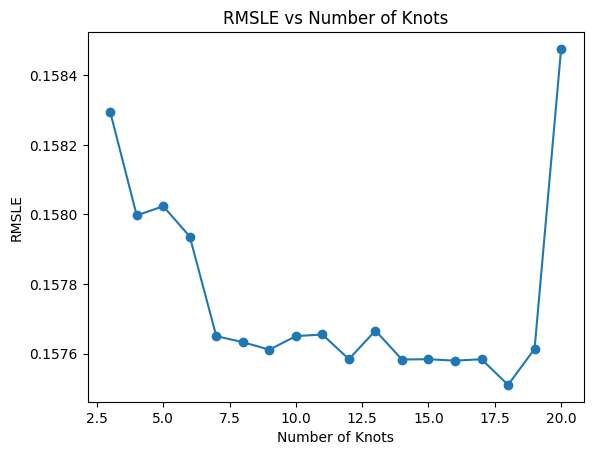

Optimal number of knots: 18
Best RMSLE: 0.15751057093873094
RMSLE (Optimized B-Splines Regression): 0.15751057093873094


In [10]:
# Function to perform grid search for the number of knots
def optimal_knots(X_train, y_train, X_val, y_val, min_knots=3, max_knots=20):
    rmsle_scores = []
    for n_knots in range(min_knots, max_knots + 1):
        spline_transformer = SplineTransformer(degree=3, n_knots=n_knots)
        model = make_pipeline(spline_transformer, LinearRegression())
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict and calculate RMSLE
        y_pred = model.predict(X_val)
        y_pred = np.maximum(y_pred, 0)  # Ensure non-negative predictions
        rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
        rmsle_scores.append(rmsle)
    
    # Plot RMSLE scores vs. number of knots
    plt.plot(range(min_knots, max_knots + 1), rmsle_scores, marker='o')
    plt.title('RMSLE vs Number of Knots')
    plt.xlabel('Number of Knots')
    plt.ylabel('RMSLE')
    plt.show()
    
    # Return the number of knots with the lowest RMSLE
    optimal_knots = np.argmin(rmsle_scores) + min_knots
    return optimal_knots, rmsle_scores[optimal_knots - min_knots]

#Assess for optimal number of knots
optimal_knots, best_rmsle = optimal_knots(X_train, y_train, X_val, y_val)
print(f"Optimal number of knots: {optimal_knots}")
print(f"Best RMSLE: {best_rmsle}")

# Now, fit the final model with the optimal number of knots
spline_transformer = SplineTransformer(degree=3, n_knots=optimal_knots)
model_spline = make_pipeline(spline_transformer, LinearRegression())
model_spline.fit(X_train, y_train)

# Final predictions and RMSLE
y_pred_spline = model_spline.predict(X_val)
y_pred_spline = np.maximum(y_pred_spline, 0)
rmsle_spline = np.sqrt(mean_squared_log_error(y_val, y_pred_spline))
print(f'RMSLE (Optimized B-Splines Regression): {rmsle_spline}')

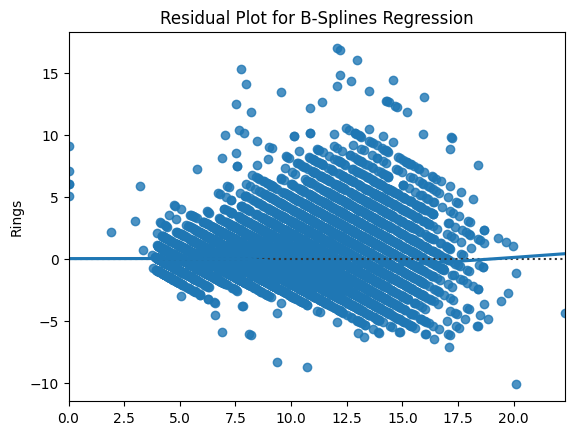

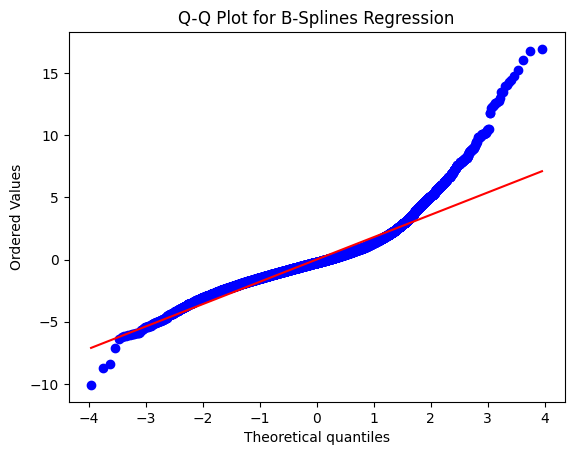

In [16]:
# Residual plots for B-Splines Regression
sns.residplot(x=y_pred_spline, y=y_val, lowess=True)
plt.title('Residual Plot for B-Splines Regression')
plt.show()

# Q-Q plots for B-Splines Regression
stats.probplot(y_val - y_pred_spline, dist="norm", plot=pylab)
pylab.title('Q-Q Plot for B-Splines Regression')
pylab.show()

Have some issues with the residuals on the larger numbers specifically, we are not fitting them very well (higher than expected residuals). 

In [17]:
# Test set predictions
test_predictions = model_spline.predict(test_data)
test_predictions = np.maximum(test_predictions, 0) # Ensure predictions are >= 0

In [18]:
# Prepare the submission file
#round the predictions to integers
submission = pd.DataFrame({
    'id': test_ID,  
    'Rings': test_predictions.round().astype(int)
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

print('Submission file created: submission.csv')



submission

Submission file created: submission.csv


,id,Rings
0,90615,8
1,90616,10
2,90617,11
3,90618,10
4,90619,8
...,...,...
60406,151021,7
60407,151022,10
60408,151023,12
60409,151024,13
